# CONFIGURACIÓN INICIAL

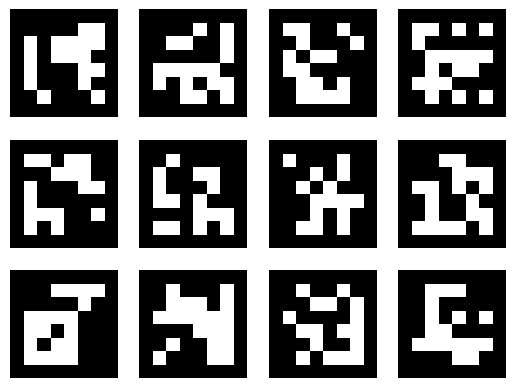

In [1]:
import numpy as np
import cv2, PIL
from cv2 import aruco
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import glob
import math
from scipy.spatial.transform import Rotation


aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)

fig = plt.figure()
nx = 4
ny = 3
for i in range(1, nx*ny+1):
    ax = fig.add_subplot(ny,nx, i)
    img = aruco.generateImageMarker(aruco_dict, i, 700)
    plt.imshow(img, cmap = mpl.cm.gray, interpolation = "nearest")
    ax.axis("off")

plt.savefig("data/markers.pdf")    
plt.show()

# FUNCIÓN DE CALIBRADO

In [2]:
def calibrate_from_template(template):

    objpoints = []
    imgpoints = []

    for plantilla in glob.glob(template):
        
        # Lectura de la imagen
        frame = cv2.imread(plantilla)
        
        # Aplicación de ArUco
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)
        parameters =  aruco.DetectorParameters()
        detector = aruco.ArucoDetector(aruco_dict, parameters)
        corners, ids, rejectedImgPoints = detector.detectMarkers(gray)
        frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
        
        for i in range(len(ids)):
            c = corners[i][0]
            plt.plot([c[:, 0].mean()], [c[:, 1].mean()], "o", label = "id={0}".format(ids[i]))

        # Lectura de ArUco
        def quad_area(data):
            l = data.shape[0]//2
            corners = data[["c1", "c2", "c3", "c4"]].values.reshape(l, 2,4)
            c1 = corners[:, :, 0]
            c2 = corners[:, :, 1]
            c3 = corners[:, :, 2]
            c4 = corners[:, :, 3]
            e1 = c2-c1
            e2 = c3-c2
            e3 = c4-c3
            e4 = c1-c4
            a = -.5 * (np.cross(-e1, e2, axis = 1) + np.cross(-e3, e4, axis = 1))
            return a
        corners2 = np.array([c[0] for c in corners])
        data = pd.DataFrame({"x": corners2[:,:,0].flatten(), "y": corners2[:,:,1].flatten()},
                           index = pd.MultiIndex.from_product( 
                                   [ids.flatten(), ["c{0}".format(i )for i in np.arange(4)+1]], 
                               names = ["marker", ""] ))


        data = data.unstack().swaplevel(0, 1, axis = 1).stack()
        data["m1"] = data[["c1", "c2"]].mean(axis = 1)
        data["m2"] = data[["c2", "c3"]].mean(axis = 1)
        data["m3"] = data[["c3", "c4"]].mean(axis = 1)
        data["m4"] = data[["c4", "c1"]].mean(axis = 1)
        data["o"] = data[["m1", "m2", "m3", "m4"]].mean(axis = 1)

        # Obtención de esquinas
        aruco1 = list(data.loc[(1, "c1")].values)
        aruco4 = list(data.loc[(4, "c2")].values)
        aruco12 = list(data.loc[(12, "c3")].values)
        aruco9 = list(data.loc[(9, "c4")].values)

        # Puntos en la imagen
        img = np.array([
                                aruco1,     aruco4,
                                aruco9,     aruco12     
                            ], dtype=np.float32)
        imgpoints.append(img)
        
        # Puntos reales
        obj = np.array([
                                    (0., 202., 0.),     (270., 202., 0.),     
                                    (0., 0., 0.),       (270., 0., 0.)    
                                ], dtype=np.float32)
        objpoints.append(obj)
        
    # Transformación de los arrays
    objpoints = np.array([objpoints], dtype=np.float32)
    objpoints = np.squeeze(objpoints)
    imgpoints = np.array([imgpoints], dtype=np.float32)
    imgpoints = np.squeeze(imgpoints)

    # Calibrado
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    # Retorno de parámetros de la cámara
    return ret, mtx, dist, rvecs, tvecs

# FUNCIÓN DE POSICIÓN

In [3]:
def get_camera_position(image, ret, mtx, dist, rvecs, tvecs):
    
    # 1. Lectura de la imagen
    photo = cv2.imread(image)
    
    # 2. Aplicación de ArUco
    gray = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)
    aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)
    parameters =  aruco.DetectorParameters()
    detector = aruco.ArucoDetector(aruco_dict, parameters)
    corners, ids, rejectedImgPoints = detector.detectMarkers(gray)
    photo_markers = aruco.drawDetectedMarkers(photo.copy(), corners, ids)
    
    for i in range(len(ids)):
        c = corners[i][0]
        plt.plot([c[:, 0].mean()], [c[:, 1].mean()], "o", label = "id={0}".format(ids[i]))
        
    # 3. Lectura de ArUco
    def quad_area(data):
        l = data.shape[0]//2
        corners = data[["c1", "c2", "c3", "c4"]].values.reshape(l, 2,4)
        c1 = corners[:, :, 0]
        c2 = corners[:, :, 1]
        c3 = corners[:, :, 2]
        c4 = corners[:, :, 3]
        e1 = c2-c1
        e2 = c3-c2
        e3 = c4-c3
        e4 = c1-c4
        a = -.5 * (np.cross(-e1, e2, axis = 1) + np.cross(-e3, e4, axis = 1))
        return a

    corners2 = np.array([c[0] for c in corners])

    data = pd.DataFrame({"x": corners2[:,:,0].flatten(), "y": corners2[:,:,1].flatten()},
                       index = pd.MultiIndex.from_product( 
                               [ids.flatten(), ["c{0}".format(i )for i in np.arange(4)+1]], 
                           names = ["marker", ""] ))


    data = data.unstack().swaplevel(0, 1, axis = 1).stack()
    data["m1"] = data[["c1", "c2"]].mean(axis = 1)
    data["m2"] = data[["c2", "c3"]].mean(axis = 1)
    data["m3"] = data[["c3", "c4"]].mean(axis = 1)
    data["m4"] = data[["c4", "c1"]].mean(axis = 1)
    data["o"] = data[["m1", "m2", "m3", "m4"]].mean(axis = 1)
    
    # 4. Obtención de esquinas
    aruco1 = list(data.loc[(1, "c1")].values)
    aruco4 = list(data.loc[(4, "c2")].values)
    aruco12 = list(data.loc[(12, "c3")].values)
    aruco9 = list(data.loc[(9, "c4")].values)
    
    # 5. Estimación de la posición
    im = photo
    size = im.shape

    imageWidth = size[1]
    imageHeight = size[0]
    imageSize = [imageWidth, imageHeight]

    points_2D = np.array([
                                (aruco1),     (aruco4),
                                (aruco9),     (aruco12)     
                            ])


    points_3D = np.array([
                                (0., 202., 0),  (270., 202., 0),
                                (0., 0., 0),  (270., 0., 0)    
                            ])

    success, rvecs, tvecs = cv2.solvePnP(points_3D, points_2D, mtx, dist, flags=cv2.SOLVEPNP_ITERATIVE)

    np_rodrigues = np.asarray(rvecs[:,:],np.float64)
    rmat = cv2.Rodrigues(np_rodrigues)[0]
    camera_position = -np.matrix(rmat).T @ np.matrix(tvecs)

    #Test the solvePnP by projecting the 3D Points to camera
    projPoints = cv2.projectPoints(points_3D, rvecs, tvecs, mtx, dist)[0]

    for p in points_2D:
     cv2.circle(im, (int(p[0]), int(p[1])), 3, (0,255,0), -1)

    for p in projPoints:
     cv2.circle(im, (int(p[0][0]), int(p[0][1])), 3, (255,0,0), -1)
    
    # 6. Estimación de la rotación

    r = Rotation.from_rotvec([rvecs[0][0],rvecs[1][0],rvecs[2][0]])
    rot = r.as_euler('xyz', degrees=True)

    # 7.Resultados finales
    
    tx = camera_position[0][0]
    ty = camera_position[1][0]
    tz = camera_position[2][0]

    rx = round(180-rot[0],5) 
    ry = round(rot[1],5) 
    rz = round(rot[2],5)
    
    position = [tx, ty, tz]
    rotation = [rx, ry, rz]
    
    return position, rotation

# TESTEO DE FUNCIONES

Posición: [matrix([[119.75087415]]), matrix([[102.21514717]]), matrix([[298.98342021]])]
Rotación: [359.94564, -3.5021, -1.58951]


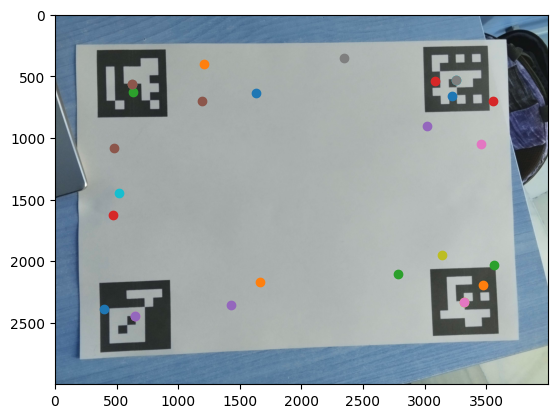

In [6]:
image = "plantilla5.jpg"
template = "plantilla*.jpg"
ret, mtx, dist, rvecs, tvecs = calibrate_from_template(template)
position, rotation = get_camera_position(image, ret, mtx, dist, rvecs, tvecs)

plt.imshow(cv2.imread(image))
print("Posición:", position)
print("Rotación:", rotation)

# FUNCIONAMIENTO DEL CÓDIGO


## CONFIGURACIÓN INICIAL

En esta parte del código se genera el diccionario de marcadores ArUco con el que trabajaremos (del que sacaremos las referencias que utilizaremos para localizar la cámara en el espacio). Esta generación no es aleatoria, por lo que tenemos la garantía de que los marcadores que utilizamos más adelante en el código y en la experimentación son los apropiados.


## FUNCIÓN DE CALIBRADO

(Provisional)


## FUNCIÓN DE POSICIÓN

En esta función se utilizan los marcadores ArUco para determinar la posición y la rotación de la cámara mediante la comparación de la posición de los marcadores en la fotografía y en la realidad.

### Parámetros

- **image**: La fotografía respecto a la que queremos obtener la posición de la cámara.

- **ret, mtx, dist, rvecs, tvecs**: Parámetros físicos de la cámara obtenidos en la funci´no de calibrado.

### Salida

- **position**: Tupla con las coordenadas de la posición de la cámara.
- **rotation**: Tupla con las coordenadas de la rotación de la cámara.

### Funcionamiento

1. Se lee *image*.

2. Se detectan los marcadores ArUco en la imagen.

3. Se almacenan los datos de los puntos relevantes de los marcadores (vértices, punto medio de cada arista, centro del marcador).

4. Se extraen los puntos que nos interesarán para nuestro trabajo; utilizamos la esquina más externa de cada uno de los cuatro marcadores utilizados:
    - Esquina 1 (superior izquierda) del marcador 1.
    - Esquina 2 (superior derecha) del marcador 4.
    - Esquina 3 (inferior derecha) del marcador 12.
    - Esquina 4 (inferior izquierda) del marcador 9.

5. Se compara la posición de los puntos en la imagen (leídos de la foto) con su posición 3D (números  fijos en la función) para estimar la posición de la cámara.

6. Se estima la rotación a partir de los parámetros de la cámara.

7. Se obtienen los resultados para la salida: *position* y *rotation*.

In [5]:
#Experimentación 1: Parámetros de entrada

a) a=2, b=0;
Al hacer esto, se obtienen estos resultados:
    img
Esto implica que calibra más de la cuenta.

b)


#Conclusiones:
Se obtienen mejores resultados con a PORQUE ....

SyntaxError: unmatched ')' (223622810.py, line 3)